In [1]:
import pandas as pd
import random
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
import seaborn as sns
from bs4 import BeautifulSoup
from urllib.request import urlopen
import seaborn as sns
from scipy.stats import norm, chi2,gumbel_r
import scipy.optimize as sco
import datetime

In [2]:
def get_close(tickers,
              start=datetime.date(datetime.date.today().year - 1, 
                datetime.date.today().month, 
                datetime.date.today().day)
                ,end=datetime.date.today()):
    
    data=pd.DataFrame()
    for ticker in tickers:

        try:

            yahoo_data=yf.Ticker(ticker)
            stock_price=yahoo_data.history(start=start,end=end,interval='1d').reset_index()
            stock_price['Date']=stock_price['Date'].dt.tz_localize(None)
            stock_price=stock_price.set_index('Date')
            stock_price[ticker]=stock_price['Close']+stock_price['Dividends'].shift(periods=-1)
            data=pd.concat([data,stock_price[ticker]],axis=1)

        except Exception as e:
            pass
        
    return data

In [3]:
stocks=pd.read_html('https://en.wikipedia.org/wiki/EURO_STOXX_50')[4]

In [4]:
tickers=stocks['Ticker'].to_list()

In [5]:
data=get_close(tickers,"2022-01-01")
data=data.dropna()
n=len(data.columns)

In [6]:
returns=np.log(1+data.pct_change())

# General Functions

In [7]:
def halton_sequences(number,base=2):
    
    #Generate Halton sequences
    
    inv_base=1/base
    
    i=number
    halton=0
    
    while i>0:
        
        digit = i%base
        halton=halton + digit*inv_base
        i=(i-digit)/base
        inv_base=inv_base/base
        
    return halton

def generate_halton(iterations,dimensions=1,base=2):
    
    #Generate a Halton Sequences at basis k , then shuffles it
    
    rng = np.random.default_rng()
    matrix=[]
    haltons=[]
    
    for i in range(iterations):
        halton=halton_sequences(i,base=base)
        haltons.append(halton)
    
    for dim in range(dimensions):
        
        matrix.append(haltons)
    
    matrix = rng.permuted(matrix, axis=1)
    return matrix

def near_psd(x, epsilon=0):
    
    #Calculate the nearest positive semi definite matrix

    if min(np.linalg.eigvals(x)) > epsilon:
        return x

    n = x.shape[0]
    var_list = np.array(np.sqrt(np.diag(x)))
    y = np.array([[x[i, j]/(var_list[i]*var_list[j]) for i in range(n)] for j in range(n)])

    eigval, eigvec = np.linalg.eig(y)
    val = np.matrix(np.maximum(eigval, epsilon))
    vec = np.matrix(eigvec)
    T = 1/(np.multiply(vec, vec) * val.T)
    T = np.matrix(np.sqrt(np.diag(np.array(T).reshape((n)) )))
    B = T * vec * np.diag(np.array(np.sqrt(val)).reshape((n)))
    near_corr = B*B.T    

    near_cov = np.array([[near_corr[i, j]*(var_list[i]*var_list[j]) for i in xrange(n)] for j in xrange(n)])
    return near_cov

In [8]:

def performance(perf,weights):
    
    #Calculate the performance of a portfolio on a daily basis
    
    return np.dot(perf,weights)


In [9]:
def rolling_var(returns,weights,window=30,Q=1):

    #This function will return the rolling VaR on a x-days window following historical,parametric and multivariate model

    value_at_risk=pd.DataFrame()

    mean=returns.rolling(window).mean().dropna()
    cov=returns.rolling(window).cov().dropna()

    index=sorted(tuple(set(cov.index.get_level_values(0))))


    var={}
    gaussian_copula={}

    for date in index:

        multivariate_var=performance(np.random.multivariate_normal(mean.loc[date],cov.loc[date],10000),weights)

        var[date]=np.percentile(multivariate_var,Q)

    multivariate_var=pd.DataFrame(var.values(),index=var.keys())

    portfolio=Portfolio(returns).portfolio(weights)

    value_at_risk['Historical']=portfolio.rolling(window=window).apply(lambda x:np.percentile(x,Q))
    value_at_risk['Parametric']=portfolio.rolling(window=window).std()*norm(loc =0 , scale = 1).ppf(Q/100)
    value_at_risk['Multivariate']=multivariate_var
    value_at_risk['Portfolio']=portfolio

    return value_at_risk.dropna()

def kupiec_test(rolling_var,Q=5):

    number_obs=rolling_var.shape[0]
    confidence=Q/100

    ret=(1+rolling_var['Portfolio']).cumprod()
    return_mean=(ret.iloc[-1])**(1/number_obs)-1

    stats={}

    stats['Proportion of failure']=[]
    stats['Kupiec Stat']=[]
    stats['P-value']=[]
    stats['Model']=[]

    for col in rolling_var.columns:

        if col=='Portfolio':

            continue

        else:

            number_violation=np.sum(np.where(rolling_var[col]>rolling_var['Portfolio'],1,0))
            number_non_violation=number_obs-number_violation
            proportion_violation=number_violation/number_obs
            proportion_non_violation=1-proportion_violation

            kupiec=2*np.log((proportion_non_violation/(1-confidence))**(number_non_violation)*
                                (proportion_violation/confidence)**number_violation)

            p_value=1-chi2.cdf(kupiec,1)

        stats['Kupiec Stat'].append(kupiec)
        stats['P-value'].append(p_value)
        stats['Proportion of failure'].append(proportion_violation)
        stats['Model'].append(col)

    stats=pd.DataFrame(stats.values(),index=stats.keys(),columns=stats['Model'])
    stats=stats.drop(stats.index[3])

    return stats


## Portfolio Construction

In [10]:
class Portfolio:
    
    #This class allows the user to calculate various metrics of a portfolio
    #and also allows to optmize the portfolio with various constraints
    
    def __init__(self,data):
        
        self.data=data

    def portfolio(self,weights):
            
        portfolio=pd.DataFrame()
        portfolio['Portfolio']=np.sum(weights*returns,axis=1)
        
        return portfolio
    
    def evolution(self,weights):
        
        portfolio=self.portfolio(weights)
        evolution=(1+portfolio).cumprod()*100
        
        return evolution
    
    def performance(self,weights):
        performance=np.sum(self.data*weights).mean()*252
        return performance
    
    def variance(self,weights):
        variance=np.sqrt(np.dot(weights.T,np.dot(self.data.cov(),weights)))*np.sqrt(252)
        return variance
    
    def sharpe_ratio(weights):
            return self.performance(weights)/self.variance(weights)

    def optimize(self,objective='minimum_variance',constraints=False):
        
            
        def sum_equal_one(weight):
            return np.sum(weight) - 1   
        
        def sharpe_ratio(weights):
            return - self.performance(weights)/self.variance(weights)
        
        def variance(weights):
            variance=np.sqrt(np.dot(weights.T,np.dot(self.data.cov(),weights)))*np.sqrt(252)
            return variance
        
        n_assets = len(self.data.columns)
        weight = np.array([1 / n_assets] * n_assets)
        bounds = tuple((0, 1) for _ in range(n_assets))
        
        if not constraints:
            
            constraints = [{'type': 'eq', 'fun': sum_equal_one}]
        
        else:
            
            constraints=[{'type': 'eq', 'fun': sum_equal_one}]+constraints
        
        if objective=='minimum_variance':

            optimum_weights = sco.minimize(variance, weight, method='SLSQP', bounds=bounds, constraints=constraints)
        
        elif objective=='sharpe_ratio':
            
            optimum_weights = sco.minimize(sharpe_ratio, weight, method='SLSQP', bounds=bounds, constraints=constraints)
            
        else:
            
            print("Objective function undefined")
            
            
        return optimum_weights.x
    
    def black_Litterman(self,P,Q,weights,risk_aversion,tau=0.025):
        
        implied_returns=risk_aversion*self.data.cov().dot(weights).squeeze()
        omega=np.diag(np.diag(P.dot(tau*self.data.cov()).dot(P.T)))
        sigma_scaled=self.data.cov()*tau
        BL_returns= implied_returns + sigma_scaled.dot(P.T).dot(np.linalg.inv(P.dot(sigma_scaled).dot(P.T))+omega).dot(Q-P.dot(implied_returns))
        inv_cov=np.linalg.inv(self.data.cov())
        BL_weights=inv_cov.dot(BL_returns)
        BL_weights=BL_weights/BL_weights.sum()
        
        return BL_weights,BL_returns

## Risk Analysis

In [11]:
class RiskAnalysis(Portfolio):
    
    
    #This class is used to assess various risk of a portfolio such as Market Risk, VaR
    # and to know which asset could possibly contribute to it
    
    def __init__(self,returns):
        
        self.returns=returns
        super().__init__(data=self.returns)
        

    def historical_var(self,weights,last_days=False,Q=5):
        
        #Return Historical VaR on the Past x days at Q confidence interval

        performance=super().portfolio(weights)
        
        if last_days:
            performance=performance[-last_days:]
            
        var=np.percentile(performance,Q)
        cvar=performance[performance<var].mean().values[0]
        
        return var,cvar
    
    
    def parametric_var(self,weights,Q=0.95):
        
        #Return parametric VaR, where assets follows a Normal Distribution
        
        intervals=np.arange(Q, 1, 0.0005, dtype=float)
        
        variance=super().variance(weights)
        VaR=variance/np.sqrt(252)*norm(loc =0 , scale = 1).ppf(1-Q)
        CVaR=variance/np.sqrt(252)*norm(loc =0 , scale = 1).ppf(1-intervals).mean()
        
        return VaR,CVaR
        
        
    def multivariate_distribution(self,
                    stress_factor=1.0,
                    iterations=10000):
        
        #Return Multivariate Distribution of a portfolio taking into account potential correlation
        
        num_asset=len(self.returns.columns)
        
        if type(stress_factor)==float:
            
            stress_vec=np.linspace(stress_factor,stress_factor,num_asset)
            
        else:       
            stress_vec=stress_factor
            
        stress_matrix=np.diag(stress_vec)
        stress_matrix=pd.DataFrame(stress_matrix,columns=self.returns.columns,index=self.returns.columns)
        
        stressed_cov=self.returns.cov().dot(stress_matrix)
        mean=self.returns.mean()
        
        multivariate=np.random.multivariate_normal(mean,stressed_cov,iterations)
        
        return multivariate
    
    def gaussian_copula(self,iterations=10000):
        
        randoms=np.random.normal(size=(10000,returns.shape[1])).T
        near_psd_corr=near_psd(self.returns.corr())
        cholesky=np.linalg.cholesky(self.returns.corr())

        simulation=np.matmul(cholesky,randoms).T
        simulation=pd.DataFrame(simulation)
        simulation.columns=returns.columns

        copula_sample=simulation*self.returns.std()+self.returns.mean()
        
        return copula_sample
    
    def monte_carlo(self,spot,horizon=20/250,iterations=100000,stress_factor=1.0):
        
        
        
        num_asset=len(self.returns.columns)
        #haltons=generate_halton(iterations,num_asset,base=2)
        randoms=np.random.normal(size=(10000,num_asset)).T
        
        # Create a stress matrix to stress the covariance matrix
        
        if type(stress_factor)==float:
            
            stress_vec=np.linspace(stress_factor,stress_factor,num_asset)
            
        else: 
            
            stress_vec=stress_factor
        
        
        #Stress the volatilities of the assets
        
        vol=self.returns.std()*np.sqrt(250)*stress_vec
        
        #Create a diagonal matrix of the stress factors
        
        stress_matrix=np.diag(stress_vec)
        stress_matrix=pd.DataFrame(stress_matrix,columns=self.returns.columns,index=self.returns.columns)
        
        #Find nearest PSD matrix and apply cholesky decomposition to create correaltion effect in Monte Carlo
        
        stressed_cov=self.returns.cov().dot(stress_matrix)
        stressed_std=np.sqrt(np.diag(stressed_cov))
        corr_matrix=stressed_cov/np.outer(stressed_std,stressed_std)
        sdp_corr_matrix=near_psd(corr_matrix)
        
        cholesky=np.linalg.cholesky(corr_matrix)
            
        drift=np.exp(-0.5*horizon*vol**2)
        factors=spot*drift
        factors_vec=factors.to_numpy().reshape(num_asset,-1)
                
        simulation=np.matmul(cholesky,randoms).T
        simulation=pd.DataFrame(simulation)
        simulation.columns=self.returns.columns
 
        
        monte_carlo=factors_vec.T*np.exp(simulation.dot(np.diag(vol))*np.sqrt(horizon))
        monte_carlo=pd.DataFrame(monte_carlo)
        monte_carlo.columns=self.returns.columns
        perf_monte_carlo=np.log(monte_carlo/spot)
        
        return monte_carlo,perf_monte_carlo
      

    
    def pca(self,num_components=2):
        
        #Returns the eigen vectors of the covariance matrix
        
        cov_matrix=self.returns.cov()
        
        cov_matrix=returns.cov()
        
        eig_val, eig_vec=np.linalg.eig(cov_matrix)
        sorted_eig_val=eig_val.argsort()[::-1]
        eig_val=eig_val[sorted_eig_val]
        eig_vec=eig_vec[:,sorted_eig_val]
        eig_val=eig_val[:num_components]
        eig_vec=eig_vec[:,0:num_components]
        
        PC={}
        
        for i in range(eig_vec.shape[1]):
            
            PC["PC" +str(i+1)]=eig_vec[:,i]/eig_vec[:,i].sum()
        
        
        portfolio_components=pd.DataFrame(PC.values(),index=PC.keys(),columns=data.columns).T
        
        return eig_val,eig_vec,portfolio_components
                
    
    

In [12]:
test=RiskAnalysis(returns)

In [13]:
num_asset=len(data.columns)
weights=np.random.rand(num_asset)
weights=weights/weights.sum()

In [14]:
weights=test.optimize(objective="minimum_variance",constraints=[{'type': 'ineq', 'fun': lambda weights: 0.1 - weights}])
weights=np.round(weights,2)

In [15]:
var,cvar=test.historical_var(weights)
var,cvar

(-0.012031844269828944, -0.017993037112134874)

In [16]:
var,cvar=test.parametric_var(weights)
var,cvar

(-0.012910440392675922, -0.016547615044334683)

In [17]:
perf=performance(test.multivariate_distribution(),weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.01240952413030561, -0.015549255857394455)

In [18]:
cop=test.gaussian_copula()
perf=performance(cop,weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.012167958029489123, -0.015552193912708628)

In [19]:
spot=data.iloc[-1]
monte_carlo=test.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1],weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.012977602590947802, -0.01630566743943465)

In [20]:
var_data=rolling_var(returns,weights,window=30,Q=1).dropna()
var_data

,Historical,Parametric,Multivariate,Portfolio
2022-02-16,-0.024382,-0.021303,-0.021836,-0.006867
2022-02-17,-0.024382,-0.021252,-0.022480,-0.003317
2022-02-18,-0.024382,-0.020808,-0.021870,-0.002776
2022-02-21,-0.024382,-0.021922,-0.022420,-0.017066
2022-02-22,-0.024382,-0.021451,-0.022613,-0.000047
...,...,...,...,...
2024-03-27,-0.005391,-0.008359,-0.007054,0.004773
2024-03-28,-0.005391,-0.008307,-0.007263,0.000010
2024-04-02,-0.006619,-0.009006,-0.008334,-0.007119
2024-04-03,-0.006619,-0.009003,-0.008216,0.000903


<AxesSubplot:>

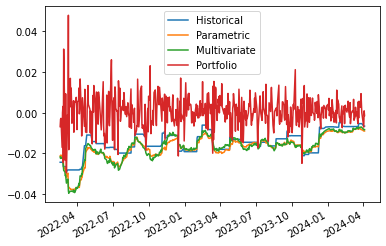

In [21]:
var_data.plot()

In [22]:
kupiec_test(var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.042146,0.011494,0.007663
Kupiec Stat,0.714519,23.361801,30.165455
P-value,0.397948,0.000001,0.0


In [23]:
eigval,eigvec,portfolio_components=test.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.68420528, 0.13533794, 0.07762128, 0.05364642, 0.04918908])

In [24]:
portfolio_components

,PC1,PC2,PC3,PC4,PC5
ADS.DE,0.028795,-0.066136,-51.682672,0.018743,-0.085360
ADYEN.AS,0.038926,-0.876479,127.679085,-0.211424,0.192339
AD.AS,0.005147,0.012343,7.158577,0.120113,0.055820
AI.PA,0.014261,-0.009003,-0.147367,0.147272,0.044027
AIR.PA,0.022250,0.098239,11.686617,0.085007,0.070207
ALV.DE,0.015828,0.118801,8.567049,0.029776,0.073206
ABI.BR,0.013960,0.056345,-3.569862,0.075878,0.150659
ASML.AS,0.027708,-0.202685,-26.921784,0.062873,-0.324001
CS.PA,0.017878,0.175788,18.248288,0.039439,0.094907
BAS.DE,0.023845,0.121952,-6.666184,-0.049401,-0.110789


<AxesSubplot:>

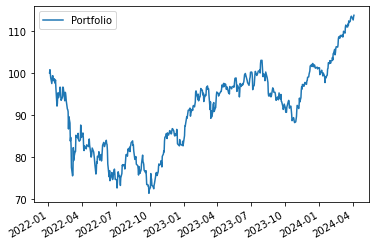

In [25]:
test.evolution(portfolio_components["PC1"]).plot()

<AxesSubplot:>

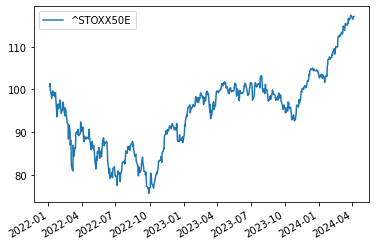

In [26]:
((1+get_close(['^STOXX50E'],"2022-01-01").pct_change()).cumprod()*100).plot()

In [27]:
index=returns.index.to_list()[::30]

In [28]:
i=0

while i< len(index)-1:
    
    used_returns=returns.loc[index[i]:index[i+1]]
    var=RiskAnalysis(used_returns).portfolio()
    print(var)
    
    i=i+1
    

(-0.012031844269828944, -0.017993037112134874)
(-0.012031844269828944, -0.017993037112134874)
(-0.012031844269828944, -0.017993037112134874)
(-0.012031844269828944, -0.017993037112134874)
(-0.012031844269828944, -0.017993037112134874)
(-0.012031844269828944, -0.017993037112134874)
(-0.012031844269828944, -0.017993037112134874)
(-0.012031844269828944, -0.017993037112134874)
(-0.012031844269828944, -0.017993037112134874)
(-0.012031844269828944, -0.017993037112134874)
(-0.012031844269828944, -0.017993037112134874)
(-0.012031844269828944, -0.017993037112134874)
(-0.012031844269828944, -0.017993037112134874)
(-0.012031844269828944, -0.017993037112134874)
(-0.012031844269828944, -0.017993037112134874)
(-0.012031844269828944, -0.017993037112134874)
(-0.012031844269828944, -0.017993037112134874)
(-0.012031844269828944, -0.017993037112134874)


In [29]:
used_returns=returns.loc[index[15]:index[18]]
np.percentile(performance(RiskAnalysis(used_returns).gaussian_copula(used_returns),weights),5)

-0.005987033749707526